In [1]:
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

cudnn.benchmark = True
plt.ion()

In [2]:
weights_path = "data/models/BestModel.pth"
image_path = "data/real/Plate1x1(3024)/IMG_1370.png"
image_path = "data/real/Plate1x1(3024)/IMG_1380.png"
#image_path = "data/real/Plate1x1(3024)/IMG_1390.png"
#image_path = "data/real/Plate1x1(3024)/IMG_1403.png"
# image_path = "data/real/Plate2x3(3021)/IMG_1373.png"
image_path = "data/demo/2x3(3021).jpg"
# image_path = "data/demo/2x3(3021).webp"
# image_path = "data/demo/4x4corner(2639).jpg"
image_path = "data/demo/keyboard.jpg"
image_path = "data/demo/housePainting.png"
class_names = ['Plate1x1(3024)', 'Plate1x10(4477)', 'Plate1x12(60479)', 'Plate1x2(3023)', 'Plate1x3(3623)', 'Plate1x4(3710)', 'Plate1x5(78329)', 'Plate1x6(3666)', 'Plate1x8(3460)', 'Plate2x10(3832)', 'Plate2x12(2445)', 'Plate2x14(91988)', 'Plate2x16(4282)', 'Plate2x2(3022)', 'Plate2x2Corner(2420)', 'Plate2x3(3021)', 'Plate2x4(3020)', 'Plate2x6(3795)', 'Plate2x8(3034)', 'Plate3x3(11212)', 'Plate3x3Corner(77844)', 'Plate4x10(3030)', 'Plate4x12(3029)', 'Plate4x4(3031)', 'Plate4x4Corner(2639)', 'Plate4x6(3032)', 'Plate4x8(3035)', 'Plate6x10(3033)', 'Plate6x12(3028)', 'Plate6x14(3456)', 'Plate6x16(3027)', 'Plate6x24(3026)', 'Plate6x6(3958)', 'Plate6x8(3036)', 'Plate8x16(92438)', 'Plate8x8(42534)']

In [3]:
# Load the model and move it to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(weights_path, map_location=device)
model = model.to(device)
model.eval()

C:\Users\Mastr\AppData\Local\Temp\ipykernel_30304\2315555165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(weights_path, map_location=device)


VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

Image size: (1420, 1220), Padding: (0, 100)


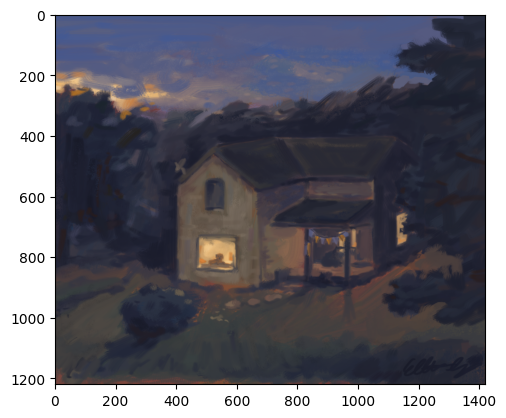

In [4]:
# Load and preprocess the input image
image = Image.open(image_path).convert("RGB")
image_size = image.size
horizontal_padding = (max(image_size) - image_size[0]) // 2
vertical_padding = (max(image_size) - image_size[1]) // 2
print(f"Image size: {image_size}, Padding: ({horizontal_padding}, {vertical_padding})")

# Visualize the image
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


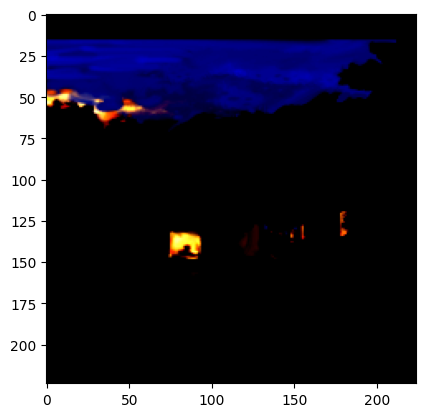

In [5]:
# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Pad(                              # Add padding to make the image square
        padding=(horizontal_padding, vertical_padding),
        fill=(0, 0, 0),                         # Black padding
        padding_mode='constant'
    ),
    transforms.Resize((224, 224)),              # Ensure the final size is 224x224
    transforms.ToTensor(),                      # Convert the image to a tensor
    transforms.Normalize(                       # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension

# visualize the image after preprocessing
plt.imshow(input_tensor.squeeze().cpu().permute(1, 2, 0))

In [6]:
# Run inference
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_idx = torch.max(output, 1)
    predicted_class = class_names[predicted_idx.item()]
    print(f"Predicted class: {predicted_class}")

    # Get the top-5 class probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)[0] * 100
    top5_prob, top5_idx = torch.topk(probabilities, 5)
    top5_classes = [class_names[idx] for idx in top5_idx.cpu().numpy()]
    print("Top-5 classes:")
    for i, (prob, cls) in enumerate(zip(top5_prob, top5_classes), 1):
        print(f"{i}. {cls} ({prob:.2f}%)")

Predicted class: Plate1x1(3024)
Top-5 classes:
1. Plate1x1(3024) (50.35%)
2. Plate1x2(3023) (14.29%)
3. Plate2x2Corner(2420) (5.63%)
4. Plate1x3(3623) (4.98%)
5. Plate2x2(3022) (3.52%)
